In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

num_cores=5
num_simulations = 500 # number of monte carlo simulations
var_scale=5.0

In [2]:
## each client actually generates data not from true beta, but from 
## true beta+some error; so if they run only sgd alone, they would never converge to the true beta.

np.set_printoptions(precision=4, suppress=True)

##global problem settings
T = 300        # total iterations/datapoints
K = 10 #np.floor(T ** 1).astype(int)             # number of decentralized nodes
d = 2             # dimension of the parameter vector
# --------------------------
# DFL Settings:
eta = 0.3
alpha = 0.8
tau = 10
 
np.random.seed(1907) # your favorite seed
client_error = np.random.normal(loc=0.0, scale=var_scale, size=(K,2)) ## errors for clients. client_error= np.zeros(K) if error for each client = 0.
#client_error = np.zeros(K)

beta_true = np.array([2.0, -3.0])
sigma = np.array([random.randint(1, 5) for _ in range(K)])
weights =  np.ones(K)/K
beta_0 = np.sum(weights[:, np.newaxis] * (beta_true + client_error), axis=0)

print(f"Client variances:{sigma**2}")
print(f"Client weights:{weights}")
#print(f"Client betas:{client_error[:, np.newaxis] + beta_true} ")
print(f"Optimal beta:{beta_0} ")
# Build a simple ring communication network
C = np.zeros((K, K))
for i in range(K):
    C[i, i] = 1/3                    # self weight
    C[i, (i-1) % K] = 1/3             # left neighbor (with wrap-around)
    C[i, (i+1) % K] = 1/3             # right neighbor

Client variances:[ 1 25 16 25 25  1  9 16  1  4]
Client weights:[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Optimal beta:[ 1.2226 -2.679 ] 


# Run DFL Local SGD

In [3]:


def run_DFL(T, K, d, eta, alpha, theta_init, tau, beta_true, beta_0, sigma, weights, C, client_error):
    """
    Runs T iterations of decentralized gradient updates.

    Parameters:
      T         : int, total number of iterations.
      K         : int, number of clients/nodes.
      d         : int, dimensionality of the parameter vector.
      eta       : float, step-size constant.
      alpha     : float, exponent controlling step decay over iterations.
      tau       : int, frequency of communication (consensus) steps.
      beta_true : np.array, the true underlying d-dimensional parameter.
      sigma     : np.array, noise standard deviations for each client (length K).
      weights   : np.array, weights for each client (typically equal to 1/K).
      C         : np.array, K x K communication matrix.
      client_error: error vector in true beta for each client.

    Returns:
      theta_traj : list of np.arrays, each an (K x d) array of client parameters at each iteration.
      error_traj : list of floats, each the L2 norm error between the over-client mean parameter estimate and beta_true.
    """
    # Initialize: theta_traj holds the initial parameters and later updates.
    #Y_traj = [np.zeros(d)]
    error_norm_traj = []
    error_traj = []
    
    #theta=np.zeros((K, d))
    theta = theta_init
    
    for t in tqdm(range(T), desc="iterates", ncols=100, position=0):
        # Use the most recent parameter matrix; .copy() is important to avoid unintended aliasing.
        #theta = theta_traj[-1].copy()

        # Local gradient descent update for each client
        for k in range(K):
            # Generate single sample for client k
            X_k = np.random.normal(loc=0.0, scale=1.0, size=(1, d))
            y_k = X_k @ (beta_true+client_error[k]) + sigma[k] * np.random.randn(1)
            
            # Compute the gradient at node k.
            # We reshape theta[k] and y_k to ensure proper dimensions.
            residual = X_k @ theta[k].reshape(-1, 1) - y_k.reshape(-1, 1)
            grad_k =  K * weights[k] * (X_k.T @ residual).flatten()
            
            # Update the parameter at client k
            theta[k] = theta[k] - eta * ((t+1) ** (-alpha)) * grad_k

        # Communication (consensus) step every tau iterations.
        if t % tau == 0:
            theta = C @ theta
        
        
        # Compute error.
        error= np.mean(theta, axis=0) - beta_0
        error_norm = np.linalg.norm(error, ord=2)
        error_norm_traj.append(error_norm)
        error_traj.append(error)     
    
    return error_norm_traj, error_traj
    


In [4]:
## run DFL; B=total number of runs to -----------

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

np.random.seed(1907)
theta_init=np.tile(beta_0, (K, 1)) + np.random.normal(loc=0, scale=0.25, size=(K, d))  # Stack row-wise K times
    
def safe_run_simulation(seed):
    np.random.seed(seed)
    try:
        error_norm_traj, error_traj = run_DFL(T, K, d, eta, alpha, theta_init, tau, beta_true, beta_0, sigma, weights, C, client_error)
        return  error_norm_traj, error_traj
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        return None


seeds = np.random.randint(0, 1000000, size=num_simulations)

with tqdm_joblib(tqdm(desc="Running simulations", total=num_simulations, ncols=100)):
    results = Parallel(n_jobs=num_cores)(delayed(safe_run_simulation)(seed) for seed in seeds)


/Users/sohambonnerjee/jupyter_env/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Running simulations:   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 4959.98it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 5001.06it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 6056.70it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 6061.22it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 5059.21it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 5418.60it/s]


In [5]:
# Calculate the partial sums of the error_traj and store the L-infinity norm of each partial sum.
def ts_calculator(error_traj):
    partial_sum = np.zeros_like(error_traj[0])
    linf_norm_traj = []
    for err in error_traj:
        partial_sum += err
        linf_norm = np.linalg.norm(partial_sum, ord=np.inf)
        linf_norm_traj.append(linf_norm)
    return (np.max(linf_norm_traj))

In [6]:
# Process the parallel simulation results by applying ts_calculator to each error_traj
ts_results = [ts_calculator(result[1]) for result in results if result is not None]
print(f"max_i |S_i|_infty for different DFL runs={ts_results[:5]}")

max_i |S_i|_infty for different DFL runs=[np.float64(88.77398262198594), np.float64(67.22124007330629), np.float64(54.79151808219229), np.float64(251.04170112916617), np.float64(78.90619340814104)]


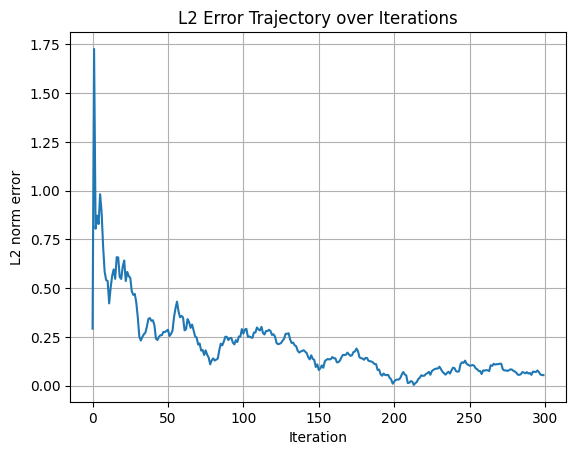

In [7]:
### plot the error trajectory of a randomly selected run -------------

import random
import matplotlib.pyplot as plt

# Filter out any failed (None) simulation results.
valid_results = [res[0] for res in results if res is not None]

if valid_results:
    # Choose one random result.
  
    # Extract error_norm_traj (the second element in our simulation tuple).
    error_norm_traj = random.choice(valid_results)
    
    # Plot the L2 norm error trajectory.
    plt.plot(error_norm_traj)
    plt.xlabel('Iteration')
    plt.ylabel('L2 norm error')
    plt.title('L2 Error Trajectory over Iterations')
    plt.grid(True)
    plt.show()
else:
    print("No valid simulation results to plot.")


# Performing Bootstrap 

# Aggregated approximation. has better theoretical accuracy.

In [8]:
errors = client_error

norms_sq = np.sum(errors**2, axis=1)

sum_diag = np.sum(weights**2 * (sigma**2 + norms_sq))

sum_outer = np.einsum('ki,kj->ij', errors, (weights**2)[:, None] * errors)

V_K = sum_diag * np.eye(d) + sum_outer #calculate V_K
A = np.eye(d) # hessian

In [9]:
K*V_K

array([[87.1044,  3.7935],
       [ 3.7935, 85.4768]])

In [10]:
V_K

array([[8.7104, 0.3793],
       [0.3793, 8.5477]])

In [11]:
def simulate_aggregate_GA(T, K, d, eta, alpha,A, V_K):
    Y = np.zeros(d)  # Y[0] = 0
    sum_Y = np.zeros(d)
    current_max = 0.0
    trajectories = []
    # Generate all Z_t upfront (n x d)
    Z = np.random.multivariate_normal(mean=np.zeros(d), cov=K * V_K, size=T)

    for t in tqdm(range(1, T+1), desc="iterates", ncols=100, position=0):
        step_size= eta * ((t+1) ** (-alpha))
        # Update rule
        Y = (1 - step_size) * Y + step_size * Z[t-1] * np.sqrt(1/K)

        # Update running sum and track max
        sum_Y += Y
        
        trajectories.append(np.linalg.norm(Y, ord=2))
        current_norm = np.linalg.norm(sum_Y, ord=2)
        if current_norm > current_max:
            current_max = current_norm

    return trajectories, current_max

In [12]:
def safe_run_GA(seed):
    np.random.seed(seed)
    try:
        Y_traj, max_norm = simulate_aggregate_GA(T, K, d, eta,alpha,A, V_K)
        return Y_traj, max_norm
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        traceback.print_exc()  # Prints full traceback
        return None


#seeds = np.random.randint(0, 1000000, size=num_simulations)

with tqdm_joblib(tqdm(desc="Running simulations", total=num_simulations, ncols=100)):
    results_GA = Parallel(n_jobs=num_cores)(delayed(safe_run_GA)(seed) for seed in seeds)

aggr_GA_results= np.array([result[1] for result in results_GA if result is not None])


Running simulations:   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

iterates: 100%|████████████████████████████████████████████████| 300/300 [00:00<00:00, 68259.26it/s]

iterates: 100%|███████████████████████████████████████████████| 300/300 [00:00<00:00, 105525.93it/s]


iterates: 100%|████████████████████████████████████████████████| 300/300 [00:00<00:00, 40645.11it/s]

iterates: 100%|████████████████�                                            | 0/300 [00:00<?, ?it/s]
��██████████████████████████████| 300/300 [00:00<00:00, 108454.68it/s]
iterates: 100%|████████████████████████████████████████████████| 300/300 [00:00<00:00, 96273.24it/s]


iterates: 100%|████████████████████████████████████████████████| 300/300 [00:00<00:00, 91598.69it/s]

iterates: 100%|████████████████████████████████████████████████| 300/300 [00:00<00:00, 96302.71it/s]


iterates: 100%|███████████████████████████████████████████████| 300/300 [00:00<00:00, 101729.42it/s]


iterates: 100%|████████████████████████████████████████████████| 300/300 [00:00<00:00, 86880.56it/s]


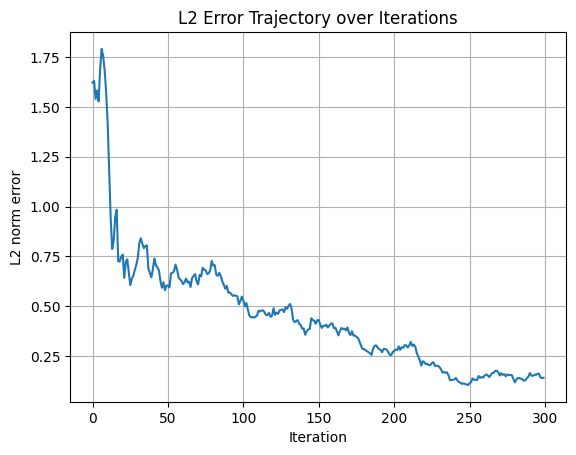

In [13]:
### plot the error trajectory of a randomly selected run -------------

import random
import matplotlib.pyplot as plt

# Filter out any failed (None) simulation results.
valid_results_Y = [result[0] for result in results_GA if result is not None]

if valid_results_Y:
    # Choose one random result.
    error_norm_traj = random.choice(valid_results_Y)
    
    # Plot the L2 norm error trajectory.
    plt.plot(error_norm_traj)
    plt.xlabel('Iteration')
    plt.ylabel('L2 norm error')
    plt.title('L2 Error Trajectory over Iterations')
    plt.grid(True)
    plt.show()
else:
    print("No valid simulation results to plot.")


# brownian motion approximation

In [14]:
def simulate_Br(V_K ,T, K, d):
    """
    Simulate Z_t ~ N(0, (K V_K)^{-1}) and compute max ||sum_{s=1}^t Z_s||_2.
    Avoids explicit matrix inversion using Cholesky decomposition.
    
    Args:
        V_K: (d x d) positive definite matrix
        K: Scaling factor (K > 0)
        n: Number of time steps
        num_simulations: Number of independent runs
        
    Returns:
        max_norms: Array of maximum norms (num_simulations,)
    """
    max_norms = np.zeros(num_simulations)
    
    Z = np.random.multivariate_normal(mean=np.zeros(d), cov= V_K, size=T)

    # Compute cumulative sums and max norm
    cumsum_Z = np.cumsum(Z, axis=0)
    norms = np.linalg.norm(cumsum_Z, ord=2, axis=1)

    
    return np.max(norms)


def safe_run_Br(seed):
    np.random.seed(seed)
    try:
        max_norm = simulate_Br(V_K ,T, K, d)
        return max_norm
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        traceback.print_exc()  # Prints full traceback
        return None

#num_simulations = 100
#seeds = np.random.randint(0, 1000000, size=num_simulations)

with tqdm_joblib(tqdm(desc="Running simulations", total=num_simulations, ncols=100)):
    results_Br = Parallel(n_jobs=num_cores)(delayed(safe_run_Br)(seed) for seed in seeds)

Br_results= np.array([result for result in results_Br if result is not None])

Running simulations:   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

# Client Level Approximation

In [15]:
norms_sq = np.sum(client_error**2, axis=1)  # shape (K,)

# Assume sigma (variances for each client's noise) is given
#sigma = np.ones(K)  # Example: Equal variances of 1

# Compute Var(Y_k) for each client (shape (K, d, d))
var_W = np.zeros((K, d, d))
for k in range(K):
    var_W[k] = (sigma[k]**2 + norms_sq[k]) * np.eye(d) + np.outer(client_error[k], client_error[k])


In [16]:
 
def run_client_GA(T, K, d, eta, alpha, tau, weights, C, var_W, A):
    
    #error_norm_traj = []
    #error_traj = []
    #Y.traj = []
        
    theta=np.zeros((K, d))
    sum_Y = np.zeros(d)
    current_max = 0.0
    
    for t in tqdm(range(T), desc="iterates", ncols=100, position=0):
        
        step_size= eta * ((t+1) ** (-alpha))
        
        for k in range(K):
        # Use the most recent parameter matrix; .copy() is important to avoid unintended aliasing.
        #theta = theta_traj[-1].copy()
        # Local gradient descent update for each client
            Z_tk = np.random.multivariate_normal(mean=np.zeros(d), cov=var_W[k])
            M_tk = K* weights[k] * Z_tk
            
            
            # Update the parameter at client k
            theta[k] = (1 - step_size) * theta[k] + step_size * M_tk

        # Communication (consensus) step every tau iterations.
        if t % tau == 0:
            theta = C @ theta
        
        Y= np.mean(theta, axis=0)
        
        sum_Y += Y
        
        #trajectories.append(np.linalg.norm(Y, ord=2))
        current_norm = np.linalg.norm(sum_Y, ord=2)
        if current_norm > current_max:
            current_max = current_norm
        
        
    return current_max

In [17]:
def safe_run_client(seed):
    np.random.seed(seed)
    try:
        max_norm = run_client_GA(T, K, d, eta, alpha, tau, weights, C, var_W, A)
        return  max_norm
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        traceback.print_exc()  # Prints full traceback
        return None


#seeds = np.random.randint(0, 1000000, size=num_simulations)

with tqdm_joblib(tqdm(desc="Running simulations", total=num_simulations, ncols=100)):
    results_client = Parallel(n_jobs=num_cores)(delayed(safe_run_client)(seed) for seed in seeds)

client_GA_results= np.array([result for result in results_client if result is not None])



Running simulations:   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 1846.78it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 1843.73it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 2006.53it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 1505.30it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 2094.49it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 2192.34it/s]


iterates: 100%|█████████████████████████████████████████████████| 300/300 [00:00<00:00, 2254.13it/s]


# Q-Q Plot

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# ======================
# NEURIPS STYLE SETTINGS
# ======================
plt.style.use('seaborn-v0_8-paper')  # Changed from 'seaborn-paper' to valid style
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 5
rcParams['axes.labelsize'] = 5
rcParams['axes.titlesize'] = 7
rcParams['legend.fontsize'] = 5
rcParams['xtick.labelsize'] = 3
rcParams['ytick.labelsize'] = 3
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.0
rcParams['lines.linewidth'] = 2

# ======================
# DATA PREPARATION
# ======================
methods = {
    'DFL': np.array(ts_results),
    'Aggregated GA': np.array(aggr_GA_results),
    'Brownian': np.array(Br_results),
    'Client GA': np.array(client_GA_results)
}

# Sort all arrays
sorted_data = {name: np.sort(data) for name, data in methods.items()}
with open(f'sorted_data_N={T},K={K},tau={tau},varscale={var_scale}.txt', 'w') as file:
    for name, data in sorted_data.items():
        file.write(f"{name}: {np.array2string(data, separator=', ')}\n")




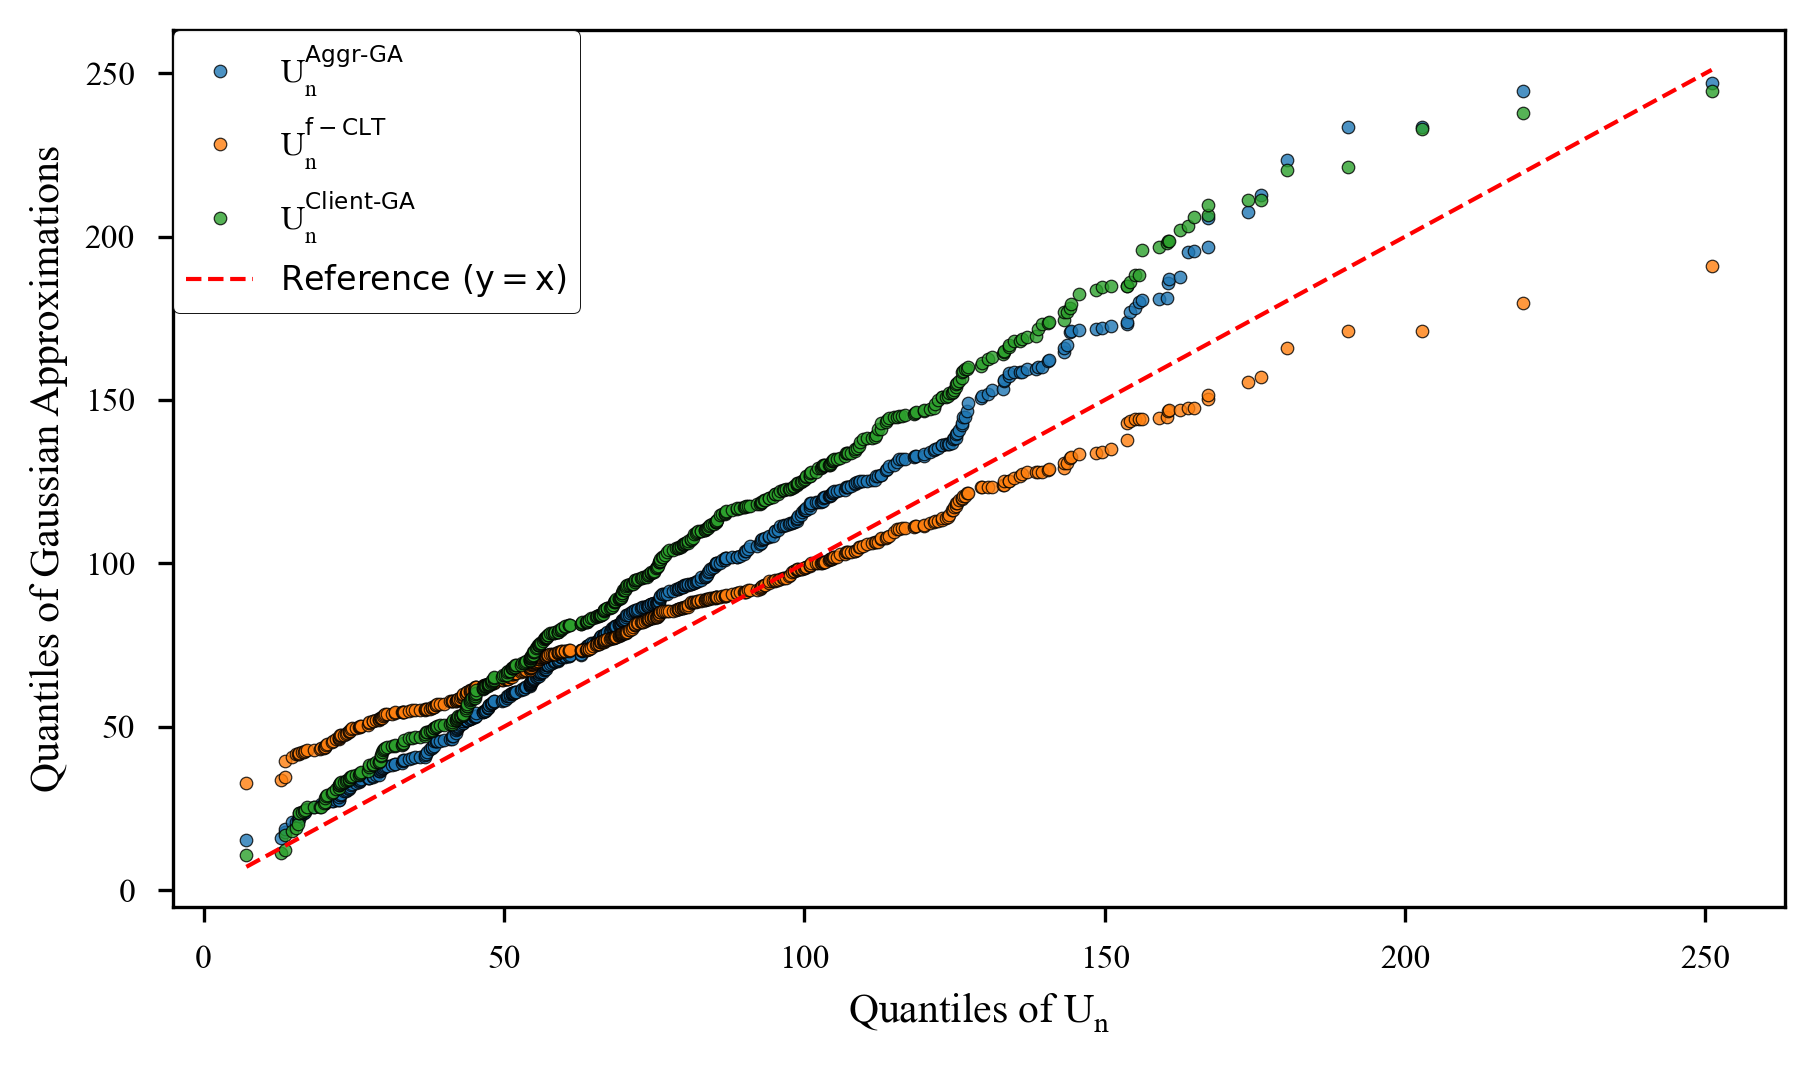

In [19]:
def parse_data_file(filename):
    data = {}
    current_key = None
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if ':' in line:  # Split key and values
                key_part, value_part = line.split(':', 1)
                current_key = key_part.strip()
                data[current_key] = []
                # Process values after colon
                nums = value_part.replace('[', '').replace(']', '').split(',')
                nums = [n.strip() for n in nums if n.strip()]
                data[current_key].extend(map(float, nums))
            else:  # Continuation of array values
                if current_key:
                    nums = line.replace('[', '').replace(']', '').split(',')
                    nums = [n.strip() for n in nums if n.strip()]
                    data[current_key].extend(map(float, nums))
    return data

# Parse and convert to numpy arrays
sorted_data = parse_data_file(f'sorted_data_N={T},K={K},tau={tau},varscale={var_scale}.txt')
sorted_data = {k: np.array(v) for k, v in sorted_data.items()}

# ======================
# VISUALIZATION (WITH FIXED LABELS)
# ======================
 # ======================
# VISUALIZATION (WITH PROPER LABEL PLACEMENT)
# ======================
fig, ax = plt.subplots(figsize=(6, 3.5))  # Increased figure size

# Custom styling with LaTeX labels
marker_styles = {
    'Aggregated GA': ('o', '#1f77b4', r'$U_n^{\mathsf{Aggr\text{-}GA}}$'),  # Bold math text
    'Brownian': ('o', '#ff7f0e', r'$U_n^{\mathsf{f-CLT}}$ '),  # Simplified label
    'Client GA': ('o', '#2ca02c', r'$U_n^{\mathsf{Client\text{-}GA}}$')
}

# Plot data
for method, (marker, color, label) in marker_styles.items():
    ax.plot(sorted_data['DFL'],
            sorted_data[method],
            marker=marker,
            linestyle='',
            markersize=3,  # Slightly larger markers
            markeredgewidth=0.3,
            markeredgecolor='k',
            label=label,
            color=color,
            alpha=0.8)

# Reference line
min_val = min(np.min(arr) for arr in sorted_data.values())
max_val = max(np.max(arr) for arr in sorted_data.values())

ax.plot([min_val, max_val], [min_val, max_val], 
        'r--', linewidth=1, label=r'$\mathsf{Reference\ (y = x)}$')

# ======================
# LEGEND ADJUSTMENTS
# ======================
# Move legend outside plot area
legend = ax.legend(
    framealpha=0.9,
    edgecolor='k',
    fontsize=8,  # Smaller font
    loc='upper left',
    borderaxespad=0.
)

# Ensure proper math rendering
plt.rcParams.update({
    'mathtext.default': 'regular',
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# Adjust plot margins to accommodate legend
plt.subplots_adjust(right=0.7)  # Make space for legend

# Rest of the plot formatting remains the same
ax.set_xlabel(r'Quantiles of ${U}_n$', fontsize=10)
ax.set_ylabel('Quantiles of Gaussian Approximations', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)

# ... (rest of grid/spine formatting from previous code)

plt.tight_layout()
plt.savefig(f'DFL_QQ_plot, n={T}, K={K}, tau={tau}, client_var={var_scale} .png', bbox_inches='tight', pad_inches=0.05, dpi=300)
plt.show()